In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
# try:
#     import timm
# except ImportError:
#     print("Please install timm: pip install timm")
#     timm = None
from transformers import ViTForImageClassification
from tqdm import tqdm
from sklearn.metrics import auc
import numpy as np
import random

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a pretrained ViT model (trained on ImageNet)
vit_model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

In [4]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [5]:
from lrp_engine import LRPEngine, checkpoint_hook

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a couple of dog and cat images from ImageNet (torchvision)
def get_imagenet_samples(num_samples=2):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Download ImageNet val subset (tiny-imagenet or use CIFAR10 for demo)
    # TODO: Mybe we should use a Hi Res dataset instead for the examples
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    # Class 3 = cat, Class 5 = dog
    imgs_list = []
    labels_list = []
    for image, label in dataset:
        # if label in [3, 5]:
        imgs_list.append(image)
        labels_list.append(label)
        if len(imgs_list) >= num_samples:
            break
    return imgs_list, labels_list

#Run forward pass and get prediction
def predict(model, img_tensor):
    with torch.no_grad():
        output_tensor = model(img_tensor)
        pred_idx = output_tensor.argmax(dim=1).item()
    return output_tensor, pred_idx

# Run LRP_promises  to get patch attributions. Not sure I have initialize first
# but it should be ok because all images are of the same size
def get_patch_attributions(model, img_tensor, pred_class, lrp_engine):
    img_tensor.requires_grad_(True)
    output = model(img_tensor)

    # Extract hidden states if available
    hidden_states = None
    if hasattr(output, 'hidden_states'):
        hidden_states = output.hidden_states
    elif isinstance(output, tuple) and len(output) > 1:
        hidden_states = output[1]
    elif isinstance(output, torch.Tensor):
        hidden_states = output
    else:
        raise RuntimeError('Could not extract hidden states from model output.')
    if hidden_states is None and hasattr(output, 'logits'):
        hidden_states = output.logits
    # Call lrp_engine as in the DNABERT-2 notebook
    return lrp_engine.run(hidden_states)

# Visualize attributions
def visualize_attributions(img_tensor, patch_relevance, title=None, show_img=True):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    if show_img:
        plt.imshow(img_np)
    # Use the first tensor in patch_relevance list? 
    # relevance_map = patch_relevance[-1].reshape(14,14)
    plt.imshow(patch_relevance, cmap='bwr', alpha=0.5 if show_img else 1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Plot image
def plot_img(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

In [7]:
vit_model.to(device)
vit_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:
num_samples = 1000
imgs_list, labels_list = get_imagenet_samples(num_samples=num_samples)
print(f"Loaded {len(imgs_list)} images")

Loaded 1000 images


In [9]:
def evaluateViT(model, engine, examples, labels, run_lrp=True):
    heatmaps = []
    pred_idxs = []
    preds = [0, 0]
    data = list(zip(examples, labels))
    for i in tqdm(range(len(examples))):
        img_tensor = examples[i]
        true_label = labels[i]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        # output_tensor, pred_idx = predict(vit_model, img_tensor)
        output = model(img_tensor)
        if isinstance(output, torch.Tensor):
            pred_idx = output.argmax(dim=-1)
        else:
            pred_idx = output.logits.argmax(dim=-1)
        if pred_idx == true_label:
            preds[0] += 1
        else:
            preds[1] += 1

        if run_lrp:
            if i == 0 and engine.param_node_inds is None:
                engine.params_to_interpret = [ img_tensor ]
            relevance_outputs= get_patch_attributions(model, img_tensor, pred_idx, engine)
            pred_idxs.append(pred_idx)
            heatmaps.append(relevance_outputs[1][0].cpu())

    return heatmaps, pred_idxs, preds

In [10]:
lrp_engine = LRPEngine(use_gamma=True, no_recompile=True)

In [11]:
# Generate our attributions
our_lrp_attrs, pred_idxs0, preds0 = evaluateViT(vit_model, lrp_engine, imgs_list, labels_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.32it/s]


In [13]:
torch.save(our_lrp_attrs, "dynamiclrp_cifar10.pt")

In [15]:
# _, pred_idxs0, preds0 = evaluateViT(vit_model, None, imgs_list, labels_list, run_lrp=False) # If only want baseline accuracy

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.57it/s]


# Define MoRF/LeRF Helpers

In [12]:
patch_size = 16
img_dims = 224
num_samples = 1000
num_patches = img_dims // patch_size
assert img_dims % patch_size == 0, f"Image dimensions {img_dims} must be divisible by patch_size {patch_size}"
occlusion_step = 4

default_args = {
    "model": vit_model,
    "patch_size": patch_size,
    "dims": img_dims,
    "occlusion_step": occlusion_step,
    "num_samples": num_samples,
    "baseline": preds0,
}

In [13]:
def compute_abpc_metrics(x_axis, y_axis_morf, y_axis_lerf, occlusion_iters):
    # ABC
    abc = auc(x_axis, y_axis_lerf) - auc(x_axis, y_axis_morf)
    
    # Comprehensiveness
    baseline = y_axis_morf[0]
    comprehensiveness = auc(x_axis, np.full_like(y_axis_morf, baseline)) - auc(x_axis, y_axis_morf)
    
    # Sufficiency  
    sufficiency = auc(x_axis, np.full_like(y_axis_lerf, baseline)) - auc(x_axis, y_axis_lerf)
    print(abc / occlusion_iters, comprehensiveness / occlusion_iters, sufficiency / occlusion_iters)

In [14]:
def visualize_abpc(baseline, morf_preds, lerf_preds, patch_size, occlusion_iters, attr_name):
    x_axis = torch.arange(0, occlusion_iters + 1, 1) * 4
    y_axis_morf = [ p[0] / (p[0] + p[1]) for p in [baseline] + morf_preds ]
    y_axis_lerf = [ p[0] / (p[0] + p[1]) for p in [baseline] + lerf_preds ]
    
    plt.plot(x_axis, y_axis_morf, color="red")
    plt.plot(x_axis, y_axis_lerf, color="blue")
    plt.title(f"MoRF and LeRF perturbation curves of {attr_name} Attribution on ViT-b-16")
    plt.xlabel(f"# {patch_size}x{patch_size} patches occluded")
    plt.ylabel("Accuracy")
    plt.show()

    compute_abpc_metrics(x_axis, y_axis_morf, y_axis_lerf, occlusion_iters)

In [15]:
def run_morf_lerf_occlusion(model, heatmaps, patch_size, dims, occlusion_step, num_samples, attr_name, baseline=None):
    print("Warning: dims expects (dimx, dimy) if giving a tuple")
    if isinstance(dims, tuple):
        assert len(dims == 2) and all(isinstance(d, int) for d in dims), "Expected dims to be either an int or tuple of two ints"
        dimx = dims[0]
        dimy = dims[1]
    elif isinstance(dims, int):
        dimx = dims
        dimy = dims
    else:
        raise TypeError("dims must be either an int or a tuple of 2 ints.")
    assert dimx % patch_size == 0 and dimy % patch_size == 0, f"boths dims x {dimx} and y {dimy} must be divisible by {patch_size}"

    num_patchesx = dimx // patch_size
    num_patchesy = dimy // patch_size
    max_patch_pool = torch.nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
    # min_patch_pool = lambda x: -torch.nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)(x)
    heatmap_pos_patches = [ max_patch_pool(hm.sum(dim=1)).squeeze(0) for hm in heatmaps ]
    # heatmap_pos_patches = [ max_patch_pool(hm).squeeze(0) for hm in heatmaps ]
    # heatmap_pos_patches = [ max_patch_pool(hm.sum(dim=1)).squeeze(0) for _, hm in heatmaps ]
    # heatmap_neg_patches = [ min_patch_pool(hm.sum(dim=1)).squeeze(0) for _, hm in heatmaps ]
    patch_mask_morf = [ patches.flatten().topk(occlusion_step).indices.cpu() for patches in heatmap_pos_patches ]
    patch_mask_lerf = [ patches.flatten().topk(occlusion_step, largest=False).indices.cpu() for patches in heatmap_pos_patches ]

    occlusion_iters = ((dimx*dimy) / (patch_size**2)) // occlusion_step
    occlusion_iters = int(occlusion_iters)
    print(f"Running {occlusion_iters} occlusion iterations with {patch_size}x{patch_size} patches")

    # Load fresh images for MoRF occlusion
    morf_imgs_list, labels_list = get_imagenet_samples(num_samples=num_samples)
    morf_preds = []

    if baseline is None:
        print("Computing baseline...")
        _, _, baseline = evaluateViT(model, None, morf_imgs_list, labels_list, run_lrp=False)
    print(f"Baseline correct/incorrect ratio is {baseline}")

    print("Generating blurred images")
    blur = T.GaussianBlur(kernel_size=51, sigma=20)
    blurred_imgs = [ blur(img) for img in morf_imgs_list ]

    # mean_pixels = [ img.mean(dim=[-1, -2]) for img in imgs_list ]
    for i in range(occlusion_iters):
        # Do occlusion
        for j in range(len(morf_imgs_list)):
            patch_inds = patch_mask_morf[j]
            for patch in patch_inds[-occlusion_step:]:
                x = (patch // num_patchesx) * patch_size
                y = (patch % num_patchesy) * patch_size
                # samplex = random.randint(0,223)
                # sampley = random.randint(0,223)
                # morf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] =  morf_imgs_list[j][:,samplex,sampley].unsqueeze(1).unsqueeze(1)
                morf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] = blurred_imgs[j][:,x:x+patch_size,y:y+patch_size]
    
        _, _, preds = evaluateViT(model, None, morf_imgs_list, labels_list, run_lrp=False)
        morf_preds.append(preds)
        print(i, preds)
        if i == occlusion_iters - 1:
            break
        patch_mask_morf = [ patches.flatten().topk((i + 2) * occlusion_step).indices.cpu() for patches in heatmap_pos_patches ]

    # Do everything again for LeRF
    lerf_imgs_list, _ = get_imagenet_samples(num_samples=num_samples)
    lerf_preds = []
    for i in range(occlusion_iters):
        # Do occlusion
        for j in range(len(lerf_imgs_list)):
            patch_inds = patch_mask_lerf[j]
            for patch in patch_inds[-occlusion_step:]:
                x = (patch // num_patchesx) * patch_size
                y = (patch % num_patchesy) * patch_size
                # samplex = random.randint(0,223)
                # sampley = random.randint(0,223)
                # lerf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] =  lerf_imgs_list[j][:,samplex,sampley].unsqueeze(1).unsqueeze(1)
                lerf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] = blurred_imgs[j][:,x:x+patch_size,y:y+patch_size]
    
        _, _, preds = evaluateViT(model, None, lerf_imgs_list, labels_list, run_lrp=False)
        lerf_preds.append(preds)
        print(i, preds)
        if i == occlusion_iters - 1:
            break
        patch_mask_lerf = [ patches.flatten().topk((i + 2) * occlusion_step, largest=False).indices.cpu() for patches in heatmap_pos_patches ]

    visualize_abpc(baseline, morf_preds, lerf_preds, 16, 49, attr_name)
    return morf_preds, lerf_preds

# Start MoRF/LeRF (scroll to bottom of outputs for metrics + curves)
Metrics are in following order: ABPC, Comprehensiveness, Sufficiency

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.63it/s]


0 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.15it/s]


1 [941, 59]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.75it/s]


2 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.64it/s]


3 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


4 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.94it/s]


5 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.14it/s]


6 [851, 149]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


7 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.09it/s]


8 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.64it/s]


9 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.71it/s]


10 [767, 233]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.38it/s]


11 [733, 267]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.89it/s]


12 [720, 280]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.81it/s]


13 [706, 294]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.28it/s]


14 [679, 321]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.76it/s]


15 [678, 322]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.83it/s]


16 [651, 349]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.47it/s]


17 [630, 370]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.47it/s]


18 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.80it/s]


19 [568, 432]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.31it/s]


20 [550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.21it/s]


21 [544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.24it/s]


22 [517, 483]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.71it/s]


23 [506, 494]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.39it/s]


24 [488, 512]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.25it/s]


25 [473, 527]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.74it/s]


26 [464, 536]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.68it/s]


27 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.82it/s]


28 [425, 575]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


29 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.68it/s]


30 [392, 608]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.83it/s]


31 [380, 620]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.70it/s]


32 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.71it/s]


33 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.46it/s]


34 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.47it/s]


35 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.68it/s]


36 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


37 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.00it/s]


38 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.90it/s]


39 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.36it/s]


40 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.25it/s]


41 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.51it/s]


42 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.70it/s]


43 [346, 654]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.30it/s]


44 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.28it/s]


45 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.85it/s]


46 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.91it/s]


47 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.88it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.41it/s]


0 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.69it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.24it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.20it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.41it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.76it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.77it/s]


6 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.54it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.94it/s]


8 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.63it/s]


9 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.49it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.50it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.78it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.86it/s]


13 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.49it/s]


14 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.89it/s]


15 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.48it/s]


16 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.23it/s]


17 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.95it/s]


18 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.41it/s]


19 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.32it/s]


20 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.14it/s]


21 [941, 59]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.12it/s]


22 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.30it/s]


23 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.04it/s]


24 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


25 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.48it/s]


26 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.61it/s]


27 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.51it/s]


28 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.30it/s]


29 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.76it/s]


30 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.24it/s]


31 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


32 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


33 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.02it/s]


34 [861, 139]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.35it/s]


35 [852, 148]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.11it/s]


36 [830, 170]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.44it/s]


37 [787, 213]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.64it/s]


38 [771, 229]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.17it/s]


39 [744, 256]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.21it/s]


40 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.06it/s]


41 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.57it/s]


42 [619, 381]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.91it/s]


43 [575, 425]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.84it/s]


44 [537, 463]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.43it/s]


45 [493, 507]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.48it/s]


46 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.90it/s]


47 [426, 574]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.28it/s]

48 [399, 601]


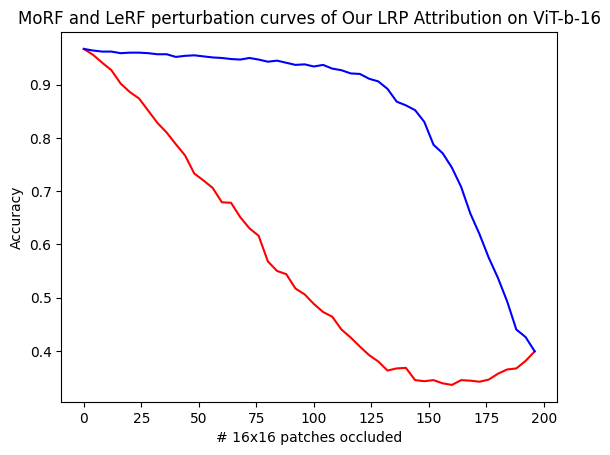

1.1875102040816323 1.6284897959183666 0.4409795918367342


In [16]:
morf_preds_ours, lerf_preds_ours = run_morf_lerf_occlusion(heatmaps=our_lrp_attrs, attr_name="Our LRP", **default_args)

# Compare against some saved attributions

In [21]:
# load external attributions
attnlrp_attrs = torch.load("../../external/LRP-eXplains-Transformers/attnlrp_cifar10_attrs.pt").unsqueeze(1).unsqueeze(1)

In [22]:
attnlrp_attrs.shape

torch.Size([1000, 1, 1, 224, 224])

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.77it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.84it/s]


1 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.36it/s]


2 [894, 106]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.06it/s]


3 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


4 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.19it/s]


5 [829, 171]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.83it/s]


6 [808, 192]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.08it/s]


7 [780, 220]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.24it/s]


8 [759, 241]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.59it/s]


9 [739, 261]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.09it/s]


10 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


11 [674, 326]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.04it/s]


12 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.87it/s]


13 [643, 357]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.36it/s]


14 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.68it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.21it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.60it/s]


17 [553, 447]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


18 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.56it/s]


19 [519, 481]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.31it/s]


20 [508, 492]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


21 [479, 521]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.80it/s]


22 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


23 [438, 562]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.53it/s]


24 [416, 584]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.71it/s]


25 [392, 608]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


26 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.60it/s]


27 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.70it/s]


28 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.21it/s]


29 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.41it/s]


30 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.81it/s]


31 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.99it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.82it/s]


33 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.78it/s]


34 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.75it/s]


35 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.90it/s]


36 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.55it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.07it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.81it/s]


39 [331, 669]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.98it/s]


40 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.30it/s]


41 [319, 681]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.78it/s]


42 [324, 676]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.27it/s]


43 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


44 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.29it/s]


45 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.70it/s]


46 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


47 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.60it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.11it/s]


1 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.30it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.28it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.61it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.02it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.99it/s]


6 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.24it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.95it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.13it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.60it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.56it/s]


12 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


13 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.17it/s]


14 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.91it/s]


15 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.50it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.49it/s]


17 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.01it/s]


18 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.72it/s]


19 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.82it/s]


20 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.56it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.11it/s]


23 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.94it/s]


24 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.18it/s]


25 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.79it/s]


26 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.50it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.25it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.88it/s]


29 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.88it/s]


30 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.48it/s]


31 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.90it/s]


32 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.16it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.30it/s]


34 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


35 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.72it/s]


36 [893, 107]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


37 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.64it/s]


38 [862, 138]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.46it/s]


39 [835, 165]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.27it/s]


40 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.58it/s]


41 [772, 228]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


42 [728, 272]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.11it/s]


43 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.52it/s]


44 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.79it/s]


45 [568, 432]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.79it/s]


46 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.56it/s]


47 [458, 542]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]

48 [399, 601]


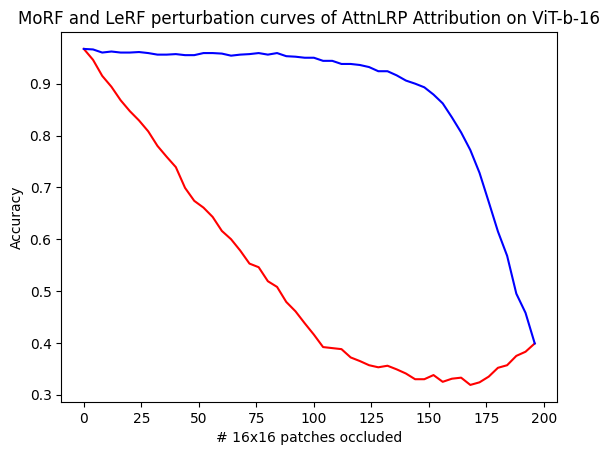

1.4565714285714282 1.781959183673469 0.3253877551020406


In [23]:
morf_preds_attnlrp, lerf_preds_attnlrp = run_morf_lerf_occlusion(heatmaps=attnlrp_attrs, attr_name="AttnLRP", **default_args)

In [32]:
# load external attributions
ig_attrs = torch.cat([ torch.load(f"../../../dynasliceBERT/captumsplitfinal/vit_captum_ig_checkpoint_{i}.pt") for i in range(1,11) ])

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.50it/s]


0 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.39it/s]


1 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.90it/s]


2 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.22it/s]


3 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.83it/s]


4 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.73it/s]


5 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.78it/s]


6 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.25it/s]


7 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.41it/s]


8 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.70it/s]


9 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.86it/s]


10 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.58it/s]


11 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.72it/s]


12 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.19it/s]


13 [901, 99]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.57it/s]


14 [894, 106]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.49it/s]


15 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.33it/s]


16 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.65it/s]


17 [863, 137]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.22it/s]


18 [862, 138]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.22it/s]


19 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.69it/s]


20 [838, 162]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


21 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


22 [809, 191]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.10it/s]


23 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.01it/s]


24 [785, 215]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.49it/s]


25 [763, 237]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.55it/s]


26 [750, 250]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.46it/s]


27 [742, 258]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.10it/s]


28 [722, 278]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.71it/s]


29 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.22it/s]


30 [682, 318]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.34it/s]


31 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.36it/s]


32 [627, 373]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.66it/s]


33 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.05it/s]


34 [587, 413]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.93it/s]


35 [564, 436]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.36it/s]


36 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.30it/s]


37 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


38 [475, 525]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.03it/s]


39 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.21it/s]


40 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


41 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.46it/s]


42 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.73it/s]


43 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


44 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.86it/s]


45 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.95it/s]


46 [405, 595]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.70it/s]


47 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.17it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.50it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.88it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


2 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


3 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.18it/s]


4 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.09it/s]


6 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


7 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.93it/s]


8 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.08it/s]


9 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.94it/s]


10 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.35it/s]


11 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.15it/s]


12 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


13 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


14 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]


15 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.98it/s]


16 [914, 86]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.02it/s]


17 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.95it/s]


18 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.36it/s]


19 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


20 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


21 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.14it/s]


22 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.48it/s]


23 [839, 161]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.89it/s]


24 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.41it/s]


25 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.71it/s]


26 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.96it/s]


27 [768, 232]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.89it/s]


28 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


29 [740, 260]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.63it/s]


30 [722, 278]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.50it/s]


31 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.23it/s]


32 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.66it/s]


33 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.30it/s]


34 [630, 370]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.99it/s]


35 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.80it/s]


36 [584, 416]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


37 [551, 449]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.68it/s]


38 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.58it/s]


39 [510, 490]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.45it/s]


40 [481, 519]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


41 [454, 546]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.25it/s]


42 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


43 [433, 567]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


44 [409, 591]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.30it/s]


45 [404, 596]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.39it/s]


46 [405, 595]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.03it/s]


47 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.58it/s]

48 [399, 601]


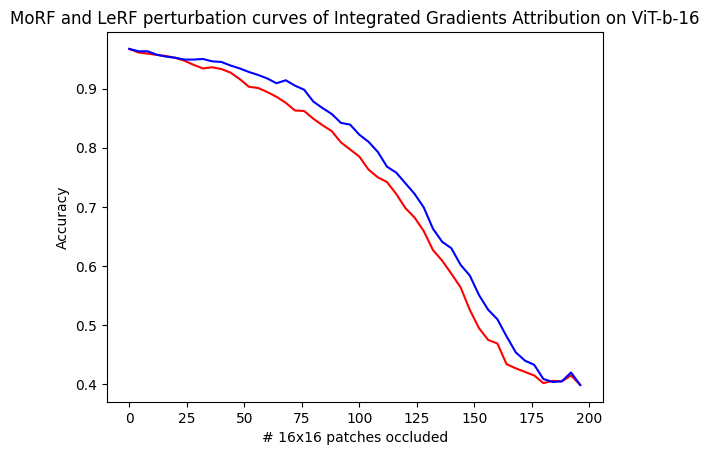

0.1013877551020406 0.946857142857142 0.8454693877551014


In [35]:
morf_preds_ig, lerf_preds_ig = run_morf_lerf_occlusion(heatmaps=ig_attrs, attr_name="Integrated Gradients", **default_args)

In [45]:
shap_attrs = torch.cat([ torch.load(f"../../../dynasliceBERT/captumsplitfinal/vit_captum_shap_checkpoint_{i}.pt") for i in range(1,11) ])

Running 49 occlusion iterations with 16x16 patches
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.66it/s]


Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.56it/s]


0 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.52it/s]


1 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.25it/s]


2 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.99it/s]


3 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.28it/s]


4 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.00it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.68it/s]


6 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.65it/s]


7 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.17it/s]


8 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.64it/s]


9 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


10 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.67it/s]


11 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.20it/s]


12 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.91it/s]


13 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.60it/s]


14 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


15 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.52it/s]


16 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.42it/s]


17 [871, 129]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.93it/s]


18 [873, 127]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.68it/s]


19 [853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


20 [839, 161]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.35it/s]


21 [831, 169]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.52it/s]


22 [809, 191]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.00it/s]


23 [798, 202]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.95it/s]


24 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.05it/s]


25 [760, 240]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.95it/s]


26 [747, 253]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


27 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.75it/s]


28 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.76it/s]


29 [690, 310]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.62it/s]


30 [670, 330]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.35it/s]


31 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.80it/s]


32 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.32it/s]


33 [610, 390]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


34 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.63it/s]


35 [550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.69it/s]


36 [536, 464]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.73it/s]


37 [509, 491]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.86it/s]


38 [491, 509]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.67it/s]


39 [470, 530]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.11it/s]


40 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]


41 [441, 559]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


42 [410, 590]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.98it/s]


43 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.71it/s]


44 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


45 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


46 [410, 590]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


47 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.06it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.48it/s]


0 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.16it/s]


1 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.70it/s]


2 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


3 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.62it/s]


4 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.78it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.07it/s]


6 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.57it/s]


7 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.49it/s]


8 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.74it/s]


9 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.72it/s]


10 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.66it/s]


11 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.40it/s]


12 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.06it/s]


13 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.42it/s]


14 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.23it/s]


15 [910, 90]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.93it/s]


16 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.82it/s]


17 [893, 107]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.24it/s]


18 [887, 113]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.08it/s]


19 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.10it/s]


20 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.54it/s]


21 [855, 145]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.61it/s]


22 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.79it/s]


23 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


24 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.32it/s]


25 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.14it/s]


26 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


27 [776, 224]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.44it/s]


28 [756, 244]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.61it/s]


29 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.84it/s]


30 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


31 [685, 315]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.80it/s]


32 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.58it/s]


33 [635, 365]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.32it/s]


34 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.68it/s]


35 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.00it/s]


36 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.94it/s]


37 [524, 476]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.12it/s]


38 [515, 485]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.17it/s]


39 [489, 511]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.33it/s]


40 [463, 537]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.73it/s]


41 [446, 554]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.16it/s]


42 [437, 563]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.93it/s]


43 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.28it/s]


44 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.55it/s]


45 [410, 590]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.07it/s]


46 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.50it/s]


47 [397, 603]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.75it/s]

48 [399, 601]


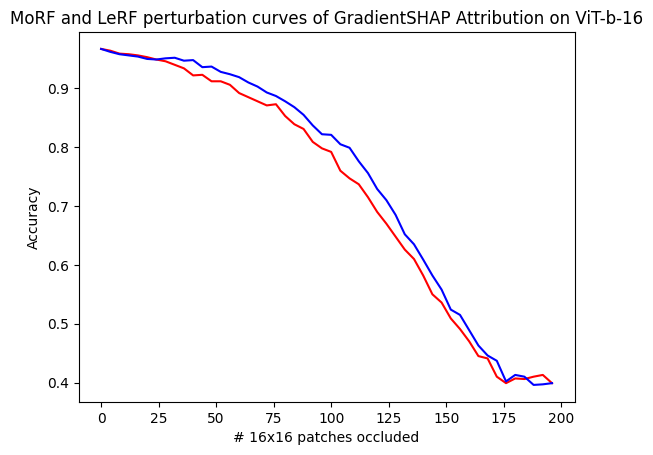

0.07395918367346987 0.944734693877551 0.8707755102040812


In [46]:
morf_preds_shap, lerf_preds_shap = run_morf_lerf_occlusion(shap_attrs, attr_name="GradientSHAP", **default_args)

In [25]:
ixg_attrs = torch.load("../../../dynasliceBERT/captumsplitfinal/vit_captum_inputxgrad_checkpoint_1.pt")

Running 49 occlusion iterations with 16x16 patches
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.33it/s]


Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.18it/s]


0 [967, 33]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.69it/s]


1 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.42it/s]


2 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.53it/s]


3 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.11it/s]


4 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.65it/s]


5 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.22it/s]


6 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


7 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.31it/s]


8 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.20it/s]


9 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.24it/s]


10 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.74it/s]


11 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


12 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.65it/s]


13 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.38it/s]


14 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.29it/s]


15 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.41it/s]


16 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.40it/s]


17 [891, 109]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.35it/s]


18 [881, 119]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


19 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


20 [844, 156]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.33it/s]


21 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


22 [817, 183]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.95it/s]


23 [803, 197]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.08it/s]


24 [798, 202]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.66it/s]


25 [772, 228]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.24it/s]


26 [761, 239]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.04it/s]


27 [741, 259]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.33it/s]


28 [736, 264]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.13it/s]


29 [709, 291]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


30 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.91it/s]


31 [678, 322]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.97it/s]


32 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.28it/s]


33 [629, 371]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.59it/s]


34 [592, 408]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.15it/s]


35 [577, 423]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


36 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.04it/s]


37 [528, 472]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.04it/s]


38 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.15it/s]


39 [493, 507]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.58it/s]


40 [462, 538]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.83it/s]


41 [451, 549]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.86it/s]


42 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.36it/s]


43 [430, 570]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.37it/s]


44 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.06it/s]


45 [426, 574]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.12it/s]


46 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.06it/s]


47 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.65it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.18it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.78it/s]


2 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.14it/s]


3 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


4 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


6 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.50it/s]


7 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


8 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.33it/s]


9 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


10 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.76it/s]


11 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.34it/s]


12 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.46it/s]


13 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


14 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.02it/s]


15 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.79it/s]


16 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.61it/s]


17 [888, 112]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.41it/s]


18 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.38it/s]


19 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.07it/s]


20 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.94it/s]


21 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.31it/s]


22 [840, 160]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


23 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.99it/s]


24 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.72it/s]


25 [782, 218]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.23it/s]


26 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.75it/s]


27 [759, 241]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.51it/s]


28 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


29 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.26it/s]


30 [682, 318]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.63it/s]


31 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.09it/s]


32 [640, 360]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.25it/s]


33 [617, 383]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


34 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.47it/s]


35 [572, 428]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


36 [552, 448]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.67it/s]


37 [529, 471]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.29it/s]


38 [508, 492]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.21it/s]


39 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


40 [460, 540]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


41 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.24it/s]


42 [438, 562]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


43 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.64it/s]


44 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.13it/s]


45 [416, 584]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.23it/s]


46 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.83it/s]


47 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.44it/s]

48 [399, 601]


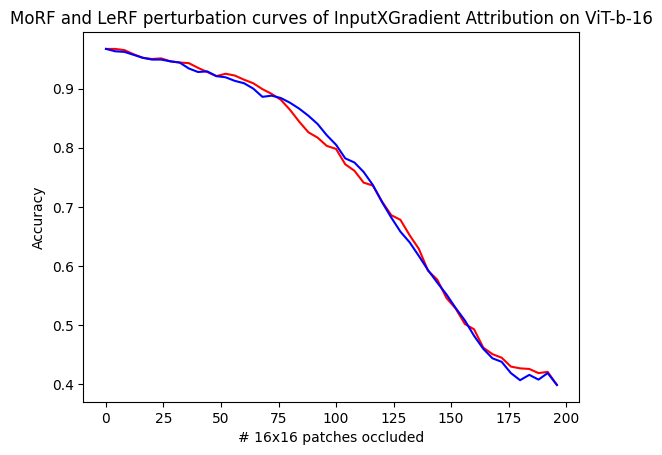

-0.003020408163264647 0.8949387755102042 0.8979591836734688


In [30]:
morf_preds_ixg, lerf_preds_ixg = run_morf_lerf_occlusion(heatmaps=ixg_attrs, attr_name="InputXGradient", **default_args)

In [43]:
random_attrs = torch.rand((1000, 1, 3, 224, 224), device=device)

Running 49 occlusion iterations with 16x16 patches
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.91it/s]


Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.25it/s]


0 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.02it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.09it/s]


2 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.77it/s]


3 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.04it/s]


4 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


5 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.51it/s]


6 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.16it/s]


7 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.31it/s]


8 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.85it/s]


9 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.77it/s]


10 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.32it/s]


11 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.20it/s]


12 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


13 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.50it/s]


14 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


15 [914, 86]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.31it/s]


16 [908, 92]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.78it/s]


17 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.33it/s]


18 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.57it/s]


19 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


20 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.97it/s]


21 [848, 152]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.53it/s]


22 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.02it/s]


23 [816, 184]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.33it/s]


24 [803, 197]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.90it/s]


25 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.87it/s]


26 [764, 236]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.00it/s]


27 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.05it/s]


28 [735, 265]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.47it/s]


29 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.70it/s]


30 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.39it/s]


31 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


32 [660, 340]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.24it/s]


33 [623, 377]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.42it/s]


34 [595, 405]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


35 [569, 431]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.64it/s]


36 [554, 446]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.68it/s]


37 [533, 467]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.16it/s]


38 [507, 493]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.48it/s]


39 [484, 516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.52it/s]


40 [464, 536]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.00it/s]


41 [452, 548]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


42 [454, 546]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.38it/s]


43 [425, 575]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.32it/s]


44 [416, 584]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.58it/s]


45 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.63it/s]


46 [428, 572]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.77it/s]


47 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.63it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.38it/s]


0 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.80it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.22it/s]


2 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.17it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.84it/s]


4 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.88it/s]


5 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.50it/s]


6 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.14it/s]


7 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.36it/s]


8 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.84it/s]


9 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.30it/s]


10 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


11 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.45it/s]


12 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.38it/s]


13 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.08it/s]


14 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


15 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.84it/s]


16 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.76it/s]


17 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.05it/s]


18 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.72it/s]


19 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


20 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.40it/s]


21 [840, 160]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.38it/s]


22 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.07it/s]


23 [807, 193]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.33it/s]


24 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.20it/s]


25 [782, 218]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.01it/s]


26 [756, 244]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.41it/s]


27 [735, 265]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.58it/s]


28 [719, 281]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.70it/s]


29 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.73it/s]


30 [676, 324]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.58it/s]


31 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.37it/s]


32 [613, 387]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.96it/s]


33 [606, 394]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.55it/s]


34 [588, 412]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.87it/s]


35 [561, 439]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.04it/s]


36 [542, 458]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


37 [509, 491]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.39it/s]


38 [499, 501]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.58it/s]


39 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


40 [459, 541]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.19it/s]


41 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.79it/s]


42 [423, 577]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.32it/s]


43 [431, 569]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.92it/s]


44 [435, 565]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.53it/s]


45 [412, 588]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.02it/s]


46 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.57it/s]


47 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]

48 [399, 601]


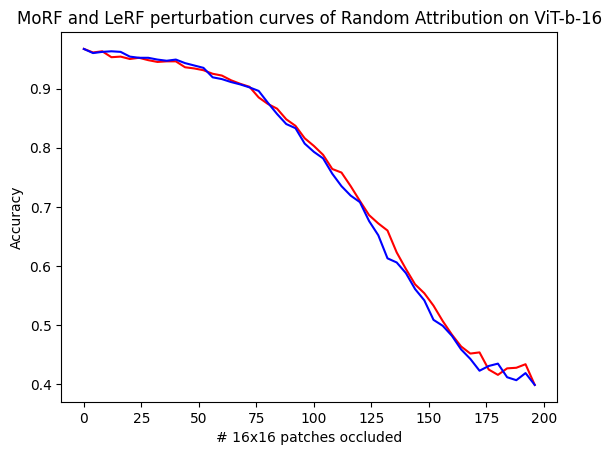

-0.02261224489795985 0.8768979591836726 0.8995102040816325


In [44]:
morf_preds_random, lerf_preds_random = run_morf_lerf_occlusion(heatmaps=random_attrs, attr_name="Random", **default_args)

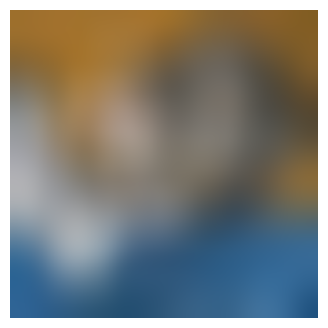

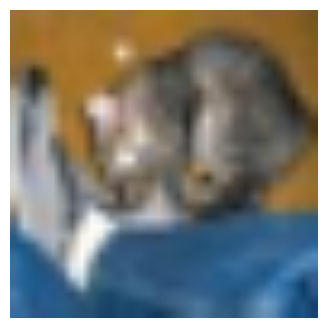

In [34]:
blurred = blur(imgs_list[0])
plot_img(blurred)
plot_img(imgs_list[0])

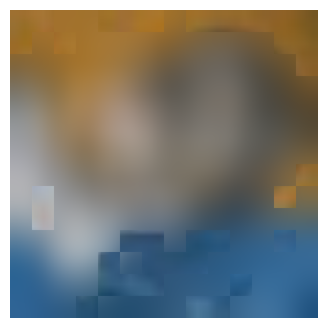

In [34]:
plot_img(morf_imgs_list[0])

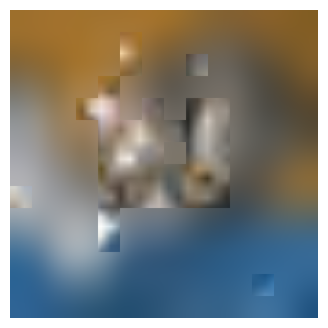

In [35]:
plot_img(lerf_imgs_list[0])

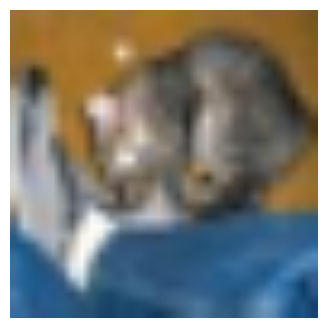

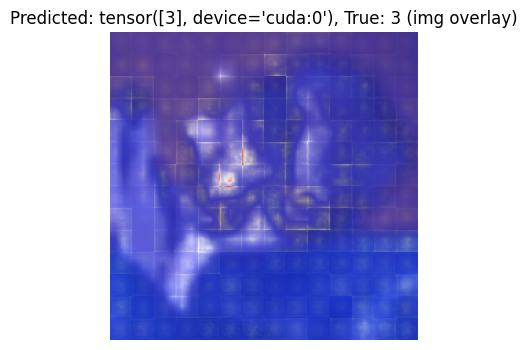

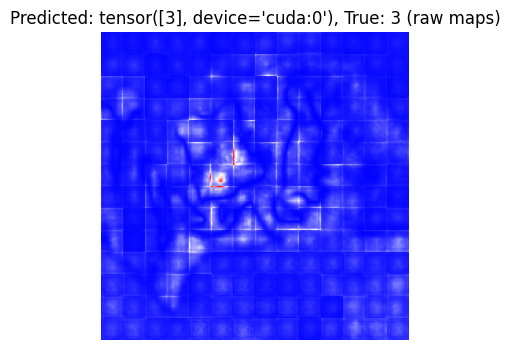

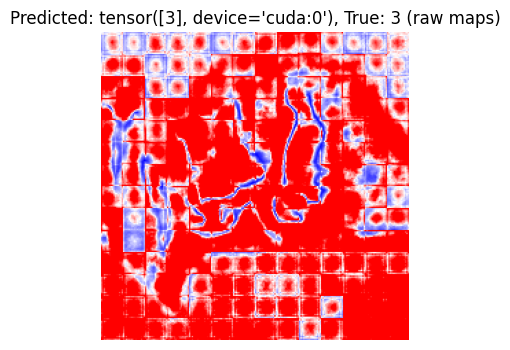

In [17]:
img_ind = 0
img_tensor = imgs_list[img_ind]
true_label = labels_list[img_ind]
pred_idx = pred_idxs0[img_ind]
hmap = our_lrp_attrs[img_ind]
total_heatmap = hmap[0][0] + hmap[0][1] + hmap[0][2]
pos_mask = total_heatmap < 0
clamped_heatmap = total_heatmap.clamp(min=total_heatmap.quantile(0.0), max=total_heatmap.quantile(0.5))
plot_img(img_tensor)
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu().detach().numpy(), title=f"Predicted: {pred_idx}, True: {true_label} (img overlay)")
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu().detach().numpy(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)
visualize_attributions(img_tensor.squeeze(0).detach(), clamped_heatmap.cpu().detach().numpy(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)

# The below is from AttnLRP attributions for comparison

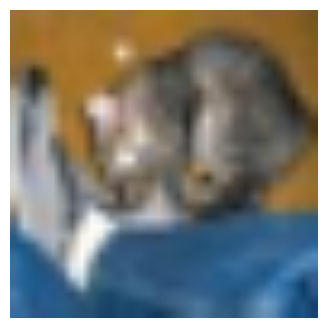

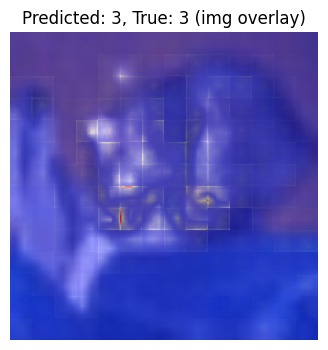

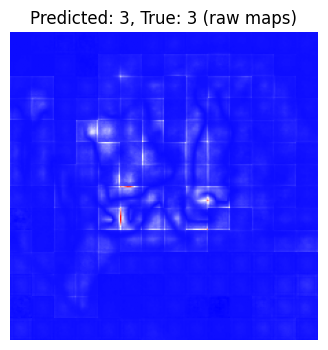

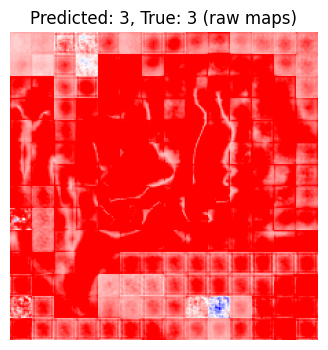

In [25]:
img_ind = 0
img_tensor = imgs_list[img_ind]
true_label = labels_list[img_ind]
pred_idx = true_label
hmap = attnlrp_attrs[img_ind]
total_heatmap = hmap.squeeze(0).squeeze(0)
# total_heatmap = hmap[0][0] + hmap[0][1] + hmap[0][2]
pos_mask = total_heatmap < 0
clamped_heatmap = total_heatmap.clamp(min=total_heatmap.quantile(0.0), max=total_heatmap.quantile(0.5))
plot_img(img_tensor)
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (img overlay)")
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)
visualize_attributions(img_tensor.squeeze(0).detach(), clamped_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)

In [11]:
promises = list(lrp_engine.promise_bucket.start_nodes_to_promise.keys())
len(promises)

76